# Machine Learning In Multi-WavelengthGalaxy/Quasars Evolution: Photometric Redshift Estimation

# Walter Silima
The code used for this project was adopted Chaka Mofokeng:
https://github.com/Mofokeng-C/Classification-Photo-z_Regression_Demo 

In [1]:
# Loading necessary modlules

import os 
import os.path as osp
import itertools
import astropy.io.fits as pf
import numpy as np
import matplotlib.pyplot as pl
pl.rcParams['axes.labelsize'] = 16
pl.rcParams['axes.titlesize'] = 16

import pandas as pd
import seaborn as sns
pl.style.use('seaborn')
import timeit

from astropy.stats import bayesian_blocks
from scipy.stats import binned_statistic,norm, bayes_mvs
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as acc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import gaussian_kde

from sklearn.linear_model import LinearRegression
from astropy.wcs import WCS # my additional package
from sklearn.tree import DecisionTreeRegressor

from scipy.stats import gaussian_kde

%matplotlib inline

In [2]:
# Defining function

def Preprocessing(filename, task='R', N=1000000):
    '''This function processes the data for a given task and returns the processed data.
    parameters:
    filename - path to the fits file
    task - process to be executed, default is Classification (c,C) another options is Regression (r,R)
    N - number of data point to use for data points
    
    returns:
    Arrays of data split into training and testng data depending on the task at hand.
    '''
    fp = pf.open(filename, memmap=True)
    data = fp[1].data
    fp.close()
    
    #Change the value of n to select only a subset of the data
    data = data[:N] # Only looking for 1000000 points
    
    #df = df.iloc[:n]
    ID = data['objID']
    u = data['dered_u']
    g = data['dered_g']
    r = data['dered_r']
    i = data['dered_i']
    z = data['dered_z']
    w1 = data['w1mpro']
    w2 = data['w2mpro']
    
    # use color as features – color is the difference of 
    # magnitudes between two different filter bands.
    # features: [u-g, g-r, r-i, i-z, z-w1, w1-w2]
    
    
     # feaures
    x = np.vstack([np.array(r), 
                   np.array(u) - np.array(g), 
                   np.array(g) - np.array(r), 
                   np.array(r) - np.array(i), 
                   np.array(i) - np.array(z), 
                   np.array(z) - np.array(w1), 
                   np.array(w1) - np.array(w2)]).T
    
    
    # keep track of all indices
    indices = np.arange(x.shape[0])
    
    # Regression
    if task == 'r' or task == 'R':
        # conditions on magnitude values, #the sources detected and making sure that there is a reasonable measurement.
        cond_u = indices[np.logical_and(u>13.0,u<20.0)]
        cond_g = indices[np.logical_and(g>14.0,g<22.2)]
        cond_r = indices[np.logical_and(r>14.0,r<22.2)]
        cond_i = indices[np.logical_and(i>14.0,i<21.3)]
        cond_z = indices[np.logical_and(z>12.0,z<20.5)]
        
        # index of where all conditions are true
        cond_u_g = cond_u[np.in1d(cond_u,cond_g)]
        cond_u_g_r = cond_u_g[np.in1d(cond_u_g,cond_r)]
        cond_u_g_r_i = cond_u_g_r[np.in1d(cond_u_g_r,cond_i)]
        cond_u_g_r_i_z = cond_u_g_r_i[np.in1d(cond_u_g_r_i, cond_z)]
    
        # get values that satisfy the conditions
        class_0 = np.array([data['specclass'][i] for i in cond_u_g_r_i_z])
        class_1 = np.array([data['specsubclass'][i] for i in cond_u_g_r_i_z])
        redshift = np.array([data['zspec'][i] for i in cond_u_g_r_i_z])
        #warning = np.array([data['zspecwarning'][i] for i in cond_ug_r_i_z]) because all the values are equal to zeros, 
        # we do not need this value.
        
        # gather all rows
        x_data = np.zeros((len(cond_u_g_r_i_z),x.shape[1]))
        for i in range(len(cond_u_g_r_i_z)):
            x_data[i] = x[cond_u_g_r_i_z[i]]
        
        # keep track of all indices
        indices = np.arange(x_data.shape[0])
        
        # for regression we only use GALAXY and QSO data
        ix = np.where(class_0 != 'STAR')[0]
        i_gal = indices[class_0 == 'GALAXY'] # index of GALAXY class
        print('Number of galaxies: {}'.format(len(i_gal)))
        
        i_qso = indices[class_0 == 'QSO'] # index of QSO class
        print('\n\nNumber of quasars: {}'.format(len(i_qso)))
        
        y_z = redshift
        #x_train, x_test, y_ztrain, y_ztest, i_train, i_test = train_test_split(x_data[ix], y_z[ix], ix, test_size=0.25) #splitting data into 75% and 25% train and test datasets, respectively
        
        return x_data, y_z, i_gal, i_qso

In [3]:
def photo_z_stats(zpredicted,ztrue):
    '''This function takes the arrays of the predicted and true redshift values
    and returns values used for evaluation of the photo-z regression process
            
    parameters:
    zpredicted - predicted redshift values from the algorithm
    ztrue - ground truth redshift values 
            
    returns:
    del_z_norm - normalized redshift estimation error
    del_z_mean - mean value of the normalized redshift estimation error (a.k.a bias)
    del_z_median - median value of the normalized redshift estimation error
    del_z_RMS - root-mean-square value of the normalized redshift estimation error (a.k.a precision)
    del_z_MAD - median-absolute-deviation value of the normalized redshift estimation error
    del_z_NMAD - normalized-median-absolute-deviation (PS: less sensitive to outliers than the RMS, thus mostly preferred value of precision )
    '''
    # evaluation measures used for photo-z regression
    del_z_norm = (zpredicted-ztrue)/(1+ztrue) # normalized redshift estimation error

    del_z_mean = np.mean(del_z_norm)

    del_z_median = np.median(del_z_norm)

    del_z_RMS = np.std(del_z_norm)

    del_z_MAD = np.median(abs(del_z_norm - np.median(del_z_median)))

    del_z_NMAD = 1.4826*del_z_MAD 

    print('delta(z)_mean = {}; delta(z)_median = {}; sigma(delta(z)) = {}; nmad(delta(z)) = {}'.format(del_z_mean,del_z_median,del_z_RMS,del_z_NMAD))
            
    return del_z_norm, del_z_mean, del_z_median, del_z_RMS, del_z_MAD, del_z_NMAD

In [4]:
def outliers_fractions(delta_z_norm,delta_z_rms):
    '''This function calculation a fraction of sources with large error for a given N.
    formula given as: normalized redshift estimation errors with values greater than 
    N times the standard deviation of the normalized redshift estimation errors.
    
    parameters:
    del_z_norm - normalized redshift estimation error
    del_z_RMS - root-mean-square value of the normalized redshift estimation error (a.k.a precision)

    returns:
    N sigma values
    '''
    sig_1 = abs(delta_z_norm) > (1.*delta_z_rms)
    sigma_1 = (float(len(delta_z_norm[sig_1]))/len(delta_z_norm))*100.

    sig_2 = abs(delta_z_norm) > (2.*delta_z_rms)
    sigma_2 = (float(len(delta_z_norm[sig_2]))/len(delta_z_norm))*100.

    sig_3 = abs(delta_z_norm) > (3.*delta_z_rms)
    sigma_3 = (float(len(delta_z_norm[sig_3]))/len(delta_z_norm))*100.

    sig_4 = abs(delta_z_norm) > 0.15
    sigma_4 = (float(len(delta_z_norm[sig_4]))/len(delta_z_norm))*100.

    print('sigma1 = {}; sigma2 = {}; sigma3 = {}; sigma0.15 = {}'.format(sigma_1,sigma_2,sigma_3,sigma_4))
    
    return sigma_1,sigma_2,sigma_3,sigma_4

In [12]:
def regressor(rg,data,labels, i_gal, i_qso, name='', cl=''):
    '''This function gives the plot of photo-z estimates of the given regressor
    parameters:
    rg - the algorithm to perform regression
    x_tr - training dataset
    x_t - test dataset
    y_ztr - photo-z training data
    y_zt - photo-z test data
    i_train - indices of training data 
    i_test - indices of test data
    i_gal - index of GALAXY specclass
    i_qso - index of QSO specclass
    name - name of the regressor
    cl - sources class ('GALAXY','QSO')
    lim - axis limits, default [0.0,0.5] ('GALAXY') ; [0.0,3.5] (QSO)
    
    returns:
    mean of the separation of the predicted and the true redshift.
    median of the separation of the predicted and the true redshift.
    rms of the separation of the predicted and the true redshift.
    nmad of the separation of the predicted and the true redshift.
    
    sigma (1*sigma, 2*sigma, 3*sigma and 4*sigma) of the separation of the predicted and the true redshift.
    plot of predicted and true redshift.
    '''
    
    
    if cl !='' and cl=='GALAXY':
       
        data = data[i_gal]
        labels = labels[i_gal]
        
        x_train, x_test, y_ztrain, y_ztest, i_train, i_test = train_test_split(data, labels, i_gal, test_size=0.20)
        
        rg.fit(x_train,y_ztrain)
        
        y_pred = rg.predict(x_test)
    
        ztest=y_ztest
        zpred=y_pred
        
        del_z_norm, del_z_mean, del_z_median, del_z_RMS, del_z_MAD, del_z_NMAD = photo_z_stats(zpred,ztest)
            
        s1, s2, s3, s4 = outliers_fractions(del_z_norm,del_z_RMS)

        str_nmad = r"$\mathbf{NMAD = %.4f}$"%del_z_NMAD
        str_del = r"$\mathbf{RMS = %.4f}$"%del_z_RMS
        
        pl.figure(figsize=(11,11))
        pl.hlines(0.0,0.,0.3,colors='k',linestyle='solid', label = 'Zspec')
        pl.scatter(ztest, -del_z_norm, c='b', lw=0, s=4)
        
        pl.hlines(del_z_NMAD,0., 0.3,colors='r',linestyle='dashed')
        pl.hlines(-del_z_NMAD,0., 0.3,colors='r',linestyle='dashed', label = 'NMAD')

        pl.xlim(0., 0.3)
        pl.ylim(-0.3, 0.2)
        pl.title('Photo-z: ' + name + '- GALAXY')
        pl.xlabel(r'$\mathbf{z_{spec}}$', fontsize=14)
        pl.ylabel(r'$\mathbf{({z_{spec} - z_{phot})/(1+z_{spec}})}$', fontsize=14)
        pl.text(0.2, -0.2, str_nmad,fontsize=14)
        pl.text(0.2, -0.22, str_del,fontsize=14)
        pl.legend(loc = 'upper left')
        pl.savefig(name+cl+'_regression.png')
        return ztest, zpred
    
    else:
        
        data = data[i_qso]
        labels = labels[i_qso]
        x_train, x_test, y_ztrain, y_ztest, i_train, i_test = train_test_split(data, labels, i_qso, test_size=0.20)
        
        # fit training data
        rg.fit(x_train,y_ztrain)
        
        # predict labels of the test data
        y_pred = rg.predict(x_test)
    
        ztest=y_ztest
        zpred=y_pred
        
        del_z_norm, del_z_mean, del_z_median, del_z_RMS, del_z_MAD, del_z_NMAD = photo_z_stats(zpred,ztest)
            
        
        s1, s2, s3, s4 = outliers_fractions(del_z_norm,del_z_RMS)

        str_nmad = r"$\mathbf{NMAD = %.4f}$"%del_z_NMAD
        str_del = r"$\mathbf{RMS = %.4f}$"%del_z_RMS
        
        pl.figure(figsize=(11,11))
        pl.hlines(0.0,0., 3.,colors='k',linestyle='solid', label = 'Zspec')
        pl.scatter(ztest, -del_z_norm, c='b', lw=0, s=4)
        
        pl.hlines(del_z_NMAD,0., 3.,colors='r',linestyle='dashed')
        pl.hlines(-del_z_NMAD, 0., 3.,colors='r',linestyle='dashed', label = 'NMAD')

        pl.xlim(0, 3)
        pl.ylim(-1, 0.5)
        pl.title('Photo-z: ' + name + '- Quasars')
        pl.xlabel(r'$\mathbf{z_{spec}}$', fontsize=14)
        pl.ylabel(r'$\mathbf{({z_{spec} - z_{phot})/(1+z_{spec}})}$', fontsize=14)
        pl.text(2.0, -0.7, str_nmad,fontsize=14)
        pl.text(2.0, -0.8, str_del,fontsize=14)
        pl.legend(loc = 'upper left')
        pl.savefig(name+cl+'_regression.png')
        return ztest, zpred

In [13]:
# making the zspec vs photo-z
def zplot(zpred, ztest, name):
    del_z_norm, del_z_mean, del_z_median, del_z_RMS, del_z_MAD, del_z_NMAD = photo_z_stats(zpred,ztest)
    
    s1, s2, s3, s4 = outliers_fractions(del_z_norm,del_z_RMS)

    str_nmad = r"$\mathbf{\sigma_{NMAD} = %.4f}$"%del_z_NMAD
    str_del = r"$\mathbf{\delta = %.4f}$"%del_z_RMS
    
    pl.figure(figsize=(9,9))
    pl.hist2d(zpred, ztest, bins=(50, 50), cmap=pl.cm.Reds)

    pl.scatter(zpred, ztest, c='b', lw=0, s=3.5)
    pl.plot([0, 0.4-del_z_NMAD], [del_z_NMAD, 0.4], ls="--", c="k", label = 'NMAD')
    pl.plot([0, 0.4], [0, 0.4], ls="--", c="r", label = 'Zspec')
    pl.plot([del_z_NMAD,0.4], [0,0.4 - del_z_NMAD], ls="--", c="k")
    pl.xlim([0.0,0.4])
    pl.ylim([0.0,0.4])
    # pl.ylim(axis_lim)
    pl.title(name)
    pl.xlabel(r'$\mathbf{z_{spec}}$', fontsize=14)
    pl.ylabel(r'$\mathbf{z_{photo}}$', fontsize=14)
    pl.colorbar()
    pl.show()
    return p1

In [8]:
# making a density plot
def denplot(zpred, ztest, name, typ = ''):
    
    if typ == 'GALAXY':
        del_z_norm, del_z_mean, del_z_median, del_z_RMS, del_z_MAD, del_z_NMAD = photo_z_stats(zpred,ztest)   
    
        s1, s2, s3, s4 = outliers_fractions(del_z_norm,del_z_RMS)

        str_nmad = r"$\mathbf{NMAD = %.4f}$"%del_z_NMAD
        str_del = r"$\mathbf{RMS = %.4f}$"%del_z_RMS
        
        # Calculate the point density
        xy = np.vstack([zpred,ztest])
        z = gaussian_kde(xy)(xy)
    
        # Sort the points by density, so that the less dense points are plotted last
        idx = z.argsort()
        zpred, ztest, z = zpred[idx], ztest[idx], z[idx]
        
        pl.figure(figsize=(11,11))
        pl.plot([0, 0.4-del_z_NMAD], [del_z_NMAD, 0.4], ls="--", c="k", label = 'NMAD')
        pl.plot([0, 0.4], [0, 0.4], ls="--", c="r", label = 'Zspec')
        pl.plot([del_z_NMAD,0.4], [0,0.4 - del_z_NMAD], ls="--", c="k")
        pl.scatter(zpred, ztest, c=z, s=3.5, cmap='jet', lw=0)
    
        pl.xlim(0, 0.3)
        pl.ylim(0, 0.3)
        pl.title(name)
        pl.xlabel(r'$\mathbf{z_{spec}}$', fontsize=14)
        pl.ylabel(r'$\mathbf{ z_{phot}}$', fontsize=14)
        pl.text(0.2, 0.01, str_nmad,fontsize=14)
        pl.legend(loc = 'upper left')
        pl.colorbar()
        pl.savefig(name+typ+'zspec.png')
        pl.show()
    
    else:
        del_z_norm, del_z_mean, del_z_median, del_z_RMS, del_z_MAD, del_z_NMAD = photo_z_stats(zpred,ztest)   
    
        s1, s2, s3, s4 = outliers_fractions(del_z_norm,del_z_RMS)

        str_nmad = r"$\mathbf{NMAD = %.4f}$"%del_z_NMAD
        str_del = r"$\mathbf{RMS = %.4f}$"%del_z_RMS
        
        # Calculate the point density
        xy = np.vstack([zpred,ztest])
        z = gaussian_kde(xy)(xy)
    
        # Sort the points by density, so that the less dense points are plotted last
        idx = z.argsort()
        zpred, ztest, z = zpred[idx], ztest[idx], z[idx]
        
        pl.figure(figsize=(11,11))
        pl.plot([0, 3.5-del_z_NMAD], [del_z_NMAD, 3.5], ls="--", c="k", label = 'NMAD')
        pl.plot([0, 3.5], [0, 3.5], ls="--", c="r", label = 'Zspec')
        pl.plot([del_z_NMAD,3.5], [0,3.5 - del_z_NMAD], ls="--", c="k")
        pl.scatter(zpred, ztest, c=z, s=3.5, cmap='jet', lw=0)
    
        pl.xlim(0, 3.)
        pl.ylim(0, 3.)
        pl.title(name)
        pl.xlabel(r'$\mathbf{z_{spec}}$', fontsize=14)
        pl.ylabel(r'$\mathbf{ z_{phot}}$', fontsize=14)
        pl.text(2., 0.5, str_nmad,fontsize=14)
        pl.legend( loc = 'upper left')
        pl.colorbar()
        pl.savefig(name+typ+'zspec.png')
        pl.show()
    
    
    
# reference
# https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density-in-matplotlib    

# Load data from the catalogue

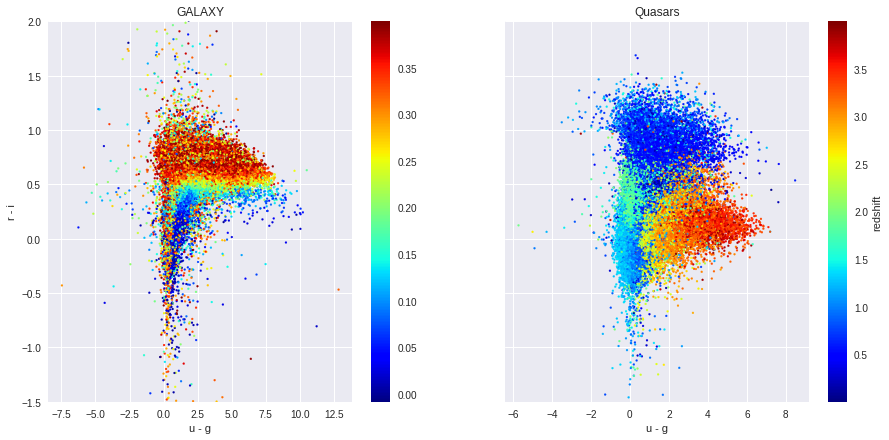

In [9]:
# loading the data from the machine
file = osp.join("sdss_all_small_dr16_allwise_red.fits")
fp = pf.open(file, memmap=True)
data = fp[1].data
fp.close

# number of elements in the data
N_all = len(data)


#Change the value of n to select only a subset of the data
N = len(data)
data = data[:N]


ID = data['objID']
u = data['dered_u']
g = data['dered_g']
r = data['dered_r']
i = data['dered_i']
z = data['dered_z']
w1 = data['w1mpro']
w2 = data['w2mpro']
   
    
#Splitting photometric data into test and train data
x = np.vstack([np.array(r), 
               np.array(u) - np.array(g), 
               np.array(g) - np.array(r), 
               np.array(r) - np.array(i), 
               np.array(i) - np.array(z), 
               np.array(z) - np.array(w1), 
               np.array(w1) - np.array(w2)]).T


# create a figure and axis
labels = ["r","u - g","g - r","r - i","i - z","z - w1","w1 - w2"]
nlabels = len(labels)

# select two random features
ilabels = np.random.choice(nlabels,2)

# select GALAXY and QSO datasets only
i_gal = np.where(data['specclass']=='GALAXY')[0] 
gal = x[i_gal] # GALAXY features
z_gal = data['zspec'][i_gal] # GALAXY spectroscopic redshifts

i_qso = np.where(data['specclass']=='QSO')[0]
qso = x[i_qso] # QSO features
z_qso = data['zspec'][i_qso] # QSO spectroscopic redshifts

# plot data points
fig, ax = pl.subplots(1,2,sharey=True,figsize=(15,7))

z_gal_new = []
gal_new = []
for i in range( len(z_gal)):
    if z_gal[i] < 0.4:
        z_gal_new.append(z_gal[i])
        gal_new.append(gal[i])
z_qso_new = []
qso_new = []
for i in range(len(z_qso)):
    if z_qso[i] < 4:
        z_qso_new.append(z_qso[i])
        qso_new.append(qso[i])

gal_new = np.array(gal_new)
qso_new = np.array(qso_new)
ax[0].set_title('GALAXY')
p = ax[0].scatter(gal_new[:,1], gal_new[:,3], c=z_gal_new, lw=0.2,s=4, cmap='jet') 

ax[0].set_xlabel(labels[1])
ax[0].set_ylabel(labels[3])
ax[0].set_ylim(-1.5, 2)
pl.colorbar(p,ax=ax[0])

ax[1].set_title('Quasars')

p1 = ax[1].scatter(qso_new[:,1], qso_new[:,3], c=z_qso_new,lw=0.2, s=4, cmap='jet')
ax[1].set_xlabel(labels[1])
ax[0].set_ylim(-1.5, 2)
pl.colorbar(p1,ax=ax[1], label='redshift')
pl.savefig('sample_data')
pl.show()


# REGRESSION

In [10]:
x_data, y_data,i_gal, i_qso = Preprocessing(file, task = 'R', N=N_all)

Number of galaxies: 285685


Number of quasars: 124688


# RF GALAXIES

delta(z)_mean = 0.0005413882936275263; delta(z)_median = 0.00034782037187764417; sigma(delta(z)) = 0.019298561500126134; nmad(delta(z)) = 0.013627145917353275
sigma1 = 20.57335876927385; sigma2 = 3.4828569928417665; sigma3 = 0.8103330591385617; sigma0.15 = 0.10851112239004497


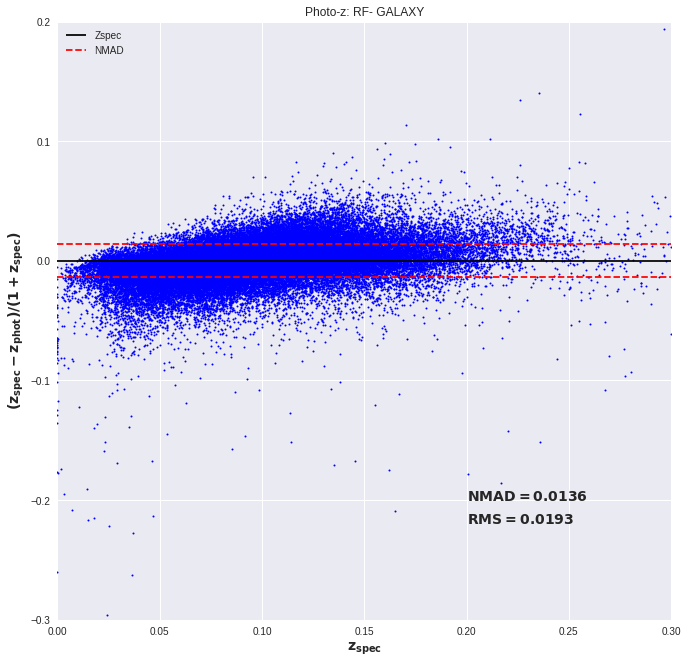

In [14]:
# RandomForestRegressor
random_forest = RandomForestRegressor(random_state = 42)

ztest_rfg, zpred_rfg = regressor(random_forest,x_data,y_data, i_gal, i_qso, 'RF', 'GALAXY')

delta(z)_mean = -0.0001449107985537731; delta(z)_median = -0.00034769945412264333; sigma(delta(z)) = 0.021010087076869587; nmad(delta(z)) = 0.013616275106774385
sigma1 = 17.49479321630467; sigma2 = 2.5430106585925056; sigma3 = 0.5635577646708787; sigma0.15 = 0.09976022542310588


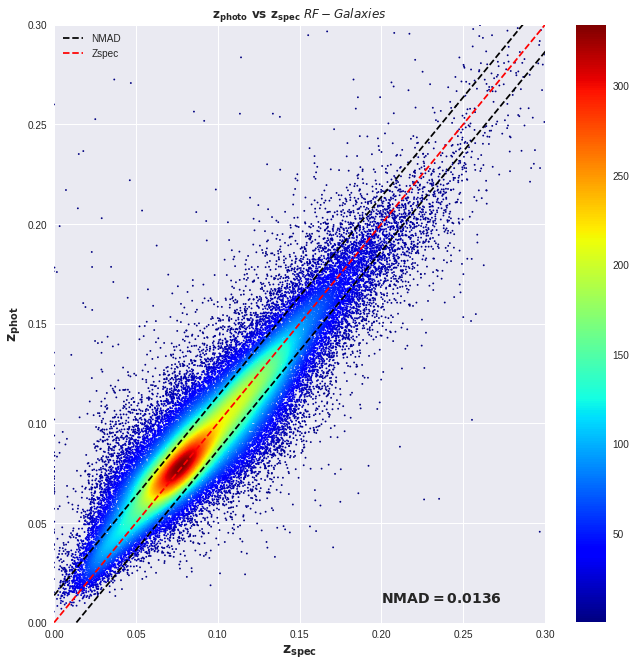

In [15]:
# making a density plot of photo-z versus spec-xz
denplot(ztest_rfg, zpred_rfg, r'$\mathbf{z_{photo}\ vs\ z_{spec}}\ RF-Galaxies$', typ = 'GALAXY')

# RF QSO

delta(z)_mean = 0.009871351040554761; delta(z)_median = 0.002814257822990867; sigma(delta(z)) = 0.10452317466061843; nmad(delta(z)) = 0.03500545619470421
sigma1 = 7.622904803913706; sigma2 = 3.3643435720587056; sigma3 = 2.0210121100328817; sigma0.15 = 4.896142433234421


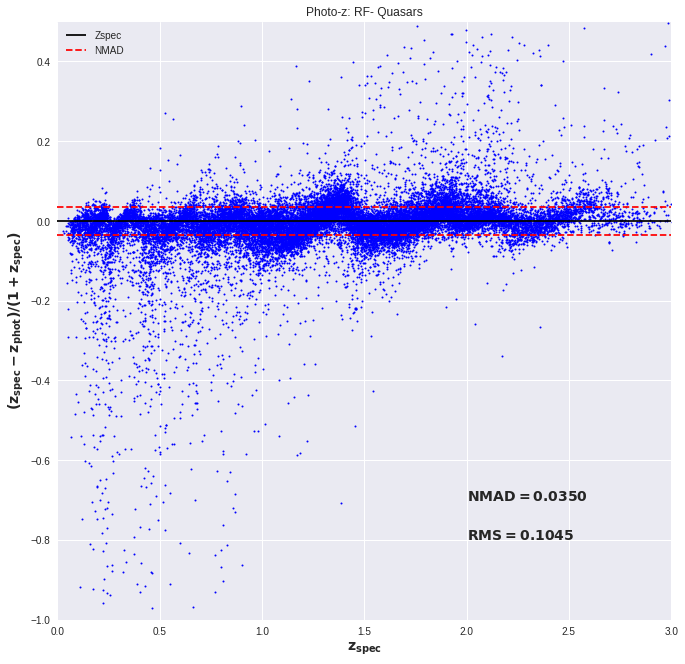

In [17]:
# Random Forest Regressor for quassars
ztest_rfq, zpred_rfq = regressor(random_forest,x_data,y_data, i_gal, i_qso, 'RF', '')

delta(z)_mean = 0.0003895917331924968; delta(z)_median = -0.0028063599697865016; sigma(delta(z)) = 0.13003656646087697; nmad(delta(z)) = 0.03488781725106621
sigma1 = 5.662041863822279; sigma2 = 2.3337877937284466; sigma3 = 1.227043066805678; sigma0.15 = 4.719704868072821


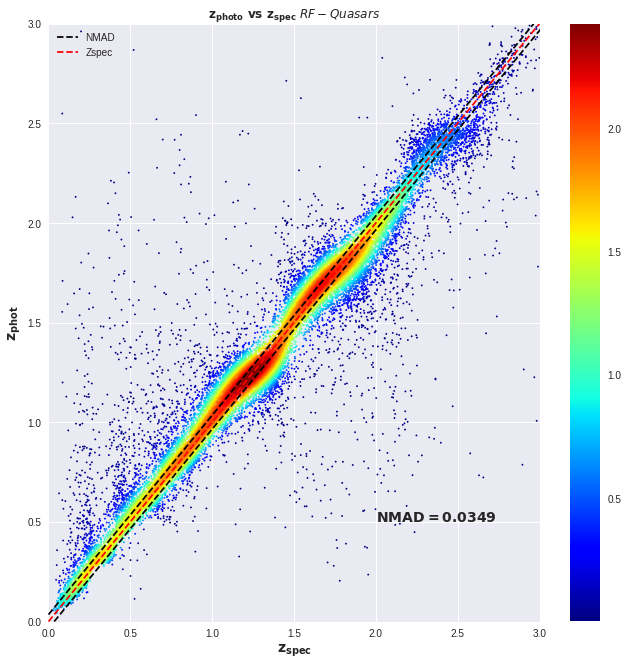

In [18]:
denplot(ztest_rfq, zpred_rfq, r'$\mathbf{z_{photo}\ vs\ z_{spec}}\ RF-Quasars$', "QSO")

# KNN REGRESSOR

# KNN GALLAXIES

delta(z)_mean = 0.00039776560151949525; delta(z)_median = 8.503189746988937e-05; sigma(delta(z)) = 0.020130708813667297; nmad(delta(z)) = 0.015268053255602716
sigma1 = 22.097765020914643; sigma2 = 3.689378161261529; sigma3 = 0.8173337767121129; sigma0.15 = 0.08225843148922764


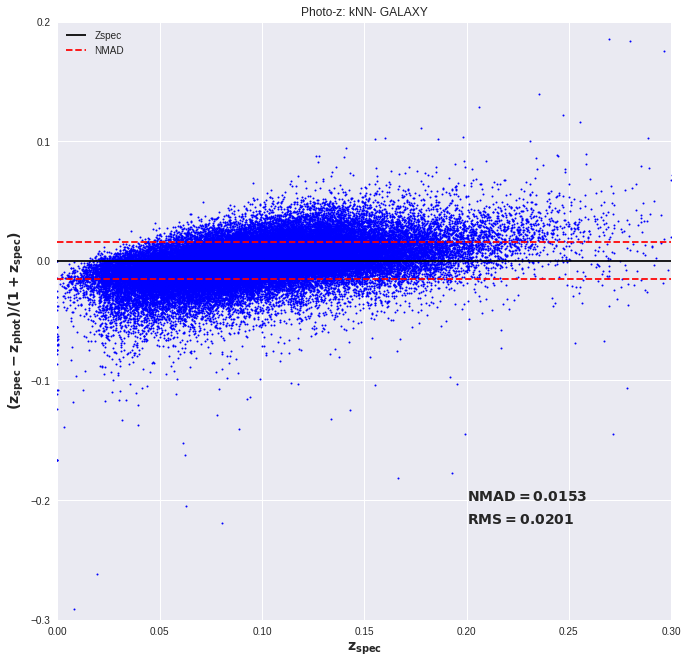

In [20]:
# kNearestRegressor Galaxies
# using 10 nearest neighbors 
knn = KNeighborsRegressor(n_neighbors=10)
ztest_knng , zpred_knng = regressor(knn,x_data,y_data, i_gal, i_qso, 'kNN', 'GALAXY')

delta(z)_mean = 3.655578984762542e-05; delta(z)_median = -8.502467244397849e-05; sigma(delta(z)) = 0.022228531539440155; nmad(delta(z)) = 0.0152564837096259
sigma1 = 18.32262806937711; sigma2 = 2.581514605247038; sigma3 = 0.5390552531634493; sigma0.15 = 0.08750896966939112


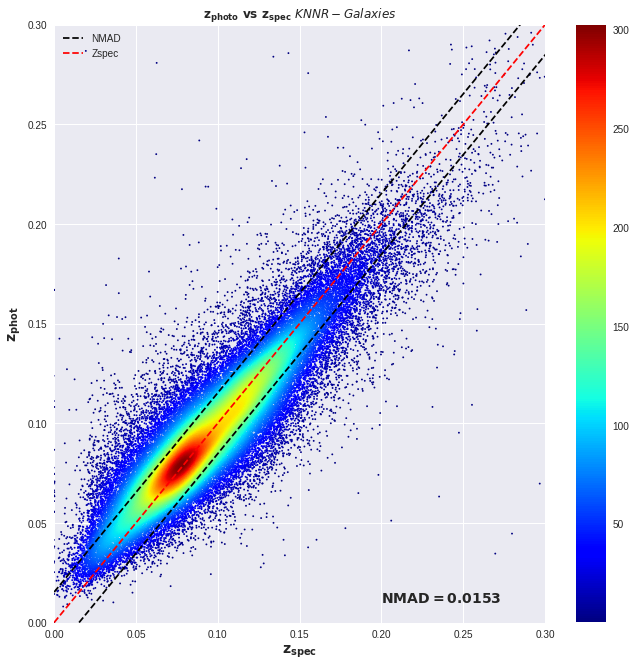

In [21]:
denplot(ztest_knng , zpred_knng, r'$\mathbf{z_{photo}\ vs\ z_{spec}}\ KNNR-Galaxies$', typ = 'GALAXY') 

# KNN QSO

delta(z)_mean = 0.007932933047413826; delta(z)_median = 0.0008414943004027009; sigma(delta(z)) = 0.1104048490524292; nmad(delta(z)) = 0.03795488214343786
sigma1 = 7.141711444382068; sigma2 = 3.2560750661640867; sigma3 = 2.0009623867190633; sigma0.15 = 4.912182211885476


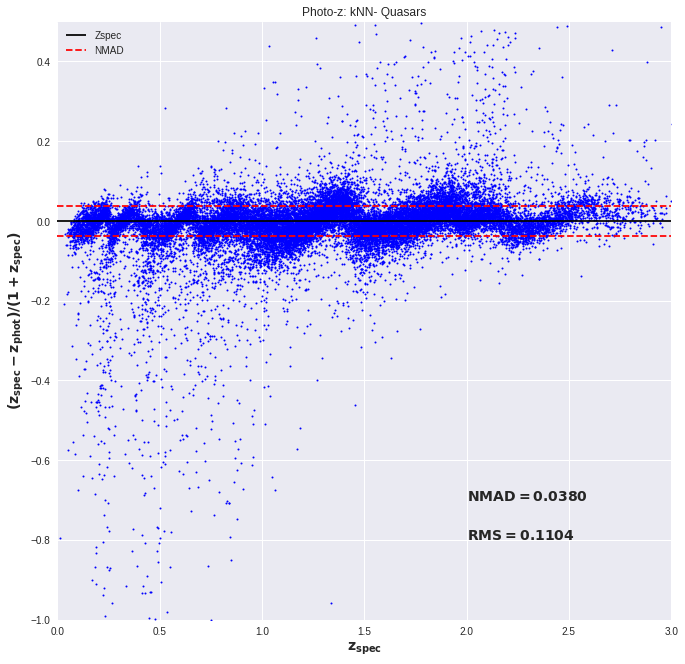

In [22]:
ztest_knnq , zpred_knnq = regressor(knn,x_data,y_data, i_gal, i_qso, 'kNN', '')

delta(z)_mean = 0.0034092545974999666; delta(z)_median = -0.0008407868444919586; sigma(delta(z)) = 0.14421935379505157; nmad(delta(z)) = 0.03792398583590984
sigma1 = 4.884112599246131; sigma2 = 2.221509343171064; sigma3 = 1.1628839522014596; sigma0.15 = 4.667575587456893


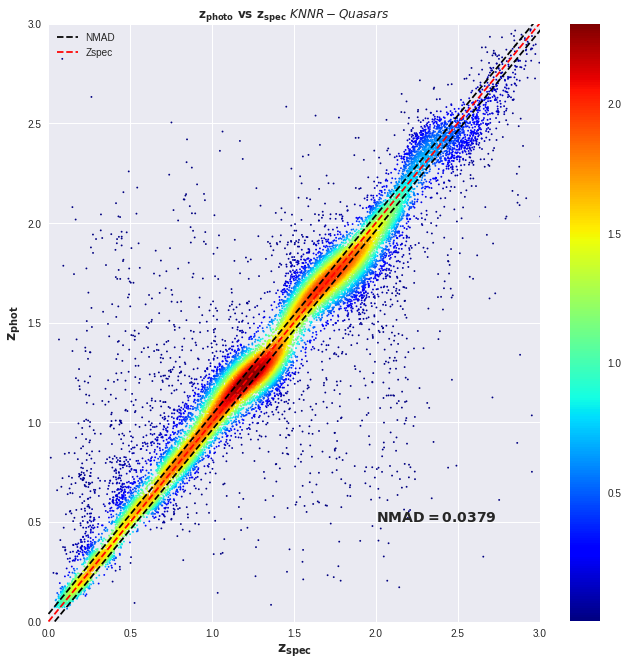

In [23]:
denplot(ztest_knnq , zpred_knnq, r'$\mathbf{z_{photo}\ vs\ z_{spec}}\ KNNR-Quasars$', 'QSO') 

Random forest basics
https://levelup.gitconnected.com/random-forest-regression-209c0f354c84
    
Random forest hyperparameter tuning
https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
    
Guide to linear regression
https://towardsdatascience.com/a-beginners-guide-to-linear-regression-in-python-with-scikit-learn-83a8f7ae2b4f
    
    
    
KNN regression

Hyperparameters tuning
https://medium.com/datadriveninvestor/k-nearest-neighbors-in-python-hyperparameters-tuning-716734bc557f

Intro to KNNR
https://www.analyticsvidhya.com/blog/2018/08/k-nearest-neighbor-introduction-regression-python/